# Simulation of User Preferences

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from vigor import generate_graphs, nobre_predicates, predicates, compute_metrics, Predicate, VIGOR, label_graphs, learn_predicates

## Generate graphs

1. Generate graphs using the fast_gnp_random_graph function from networkx
2. Calculate statistics for each graph

In [ ]:
file_path = '../data/generated_graphs_example.csv'
# graphs = generate_graphs(1000, 2, 200, file_path=file_path)
graphs = pd.read_csv(f'{file_path}')

Generated statistics for graph 0 {'graph_type': 4, 'is_directed_int': 0, 'has_spatial_attributes': 0, 'has_temporal_attributes': 1, 'is_bipartite': 1, 'n_components': 8, 'avg_betweenness_centrality': 0.02988505747126437, 'avg_closeness_centrality': 0.5475830659433913, 'avg_eigenvector_centrality': 0.1741207756632428, 'avg_degree': 7.333333333333333, 'std_degree': 2.2793425145972632, 'clustering_coefficient': 0.21762274762274764, 'transitivity': 0.22538860103626943, 'modularity': -0.00016528925619843345, 'communities': 2, 'avg_shortest_path_length': 1.8367816091954023, 'radius': 2, 'diameter': 3, 'assortativity': -0.17654923457450336, 'vertex_connectivity': 2, 'eccentricity_avg': 2.966666666666667, 'n_nodes': 30, 'node_types': 3, 'node_attributes': 11, 'number_of_isolates': 0, 'density': 0.25287356321839083, 'edge_types': 4, 'edge_attributes': 9, 'n_parallel_edges': 3, 'n_self_loops': 1}
Generated statistics for graph 1 {'graph_type': 4, 'is_directed_int': 1, 'has_spatial_attributes': 0

/Users/sjoerdvink/Developer/visualization-recommendation/.venv/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


Generated statistics for graph 14 {'graph_type': 3, 'is_directed_int': 0, 'has_spatial_attributes': 1, 'has_temporal_attributes': 1, 'is_bipartite': 1, 'n_components': 0, 'avg_betweenness_centrality': 0.00885288487831556, 'avg_closeness_centrality': 0.4166811719741132, 'avg_eigenvector_centrality': 0.07478369068659502, 'avg_degree': 10.583850931677018, 'std_degree': 3.071154111671987, 'clustering_coefficient': 0.06850703967024174, 'transitivity': 0.06928251121076233, 'modularity': -1.7219907866560946e-05, 'communities': 2, 'avg_shortest_path_length': 2.407608695652174, 'radius': 3, 'diameter': 4, 'assortativity': 0.012032191071916692, 'vertex_connectivity': 5, 'eccentricity_avg': 3.360248447204969, 'n_nodes': 161, 'node_types': 3, 'node_attributes': 7, 'number_of_isolates': 0, 'density': 0.06614906832298137, 'edge_types': 2, 'edge_attributes': 11, 'n_parallel_edges': 0, 'n_self_loops': 0}
Generated statistics for graph 15 {'graph_type': 3, 'is_directed_int': 0, 'has_spatial_attributes'

In [ ]:
graphs.head()

,graph_type,is_directed_int,has_spatial_attributes,has_temporal_attributes,is_bipartite,n_components,avg_betweenness_centrality,avg_closeness_centrality,avg_eigenvector_centrality,avg_degree,...,2.129032258064516,62,3.1,10.1,0.2,0.28239026969857217,3.2,1.2,1.3,4
0,4,1,1,0,0,6,0.004762,0.596901,0.082760,46.305556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,0,0,0,0,3,0.008252,0.574299,0.102541,23.608696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,1,0,1,0,2,0.016667,0.155556,0.284518,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,0,0,1,2,0.006020,0.582964,0.089947,34.049587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,1,0,0,0,0,0.166667,0.750000,0.500000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
graphs = graphs[['graph_type', 'n_nodes', 'density']]

In [ ]:
graphs

,graph_type,n_nodes,density
0,4,144,0.323815
1,4,92,0.259436
2,4,6,0.133333
3,4,121,0.283747
4,2,4,0.666667
...,...,...,...
159,4,20,0.468421
160,4,115,0.268345
161,4,57,0.164160
162,4,95,0.146697


## Sample designers

We evaluate the ability of VIGOR to recover the rules that were used to represent simulated users. We design 3 versions of this simulated user: bob_informed, who follows the rules 100\% of the time; bob_semi_informed, who follows the rules 75\% of the time and chooses other visualizations randomly the other 25\% of the time; and bob_uninformed who follows the rules 50\% of the time and chooses other visualizations randomly the other 50\% of the time.

In [ ]:
informed = label_graphs(graphs, predicates, conformance=1)
semi_informed = label_graphs(graphs, predicates, conformance=0.75)
uninformed = label_graphs(graphs, predicates, conformance=0.5)

In [ ]:
informed

0       MATRIX
1       MATRIX
2       MATRIX
3       MATRIX
4       MATRIX
        ...   
159     MATRIX
160     MATRIX
161    PAOHVIS
162    PAOHVIS
163     MATRIX
Length: 164, dtype: object

### Learning predicates from labeled data

In [ ]:
graphs['graph_type'].value_counts()

graph_type
4    108
3     29
2     17
1     10
Name: count, dtype: int64

In [ ]:
graph_types = graphs['graph_type'].unique()
graphs['graph_type_' + pd.Series(graph_types).astype(str)] = (graphs['graph_type'].values[None] == graph_types[:,None]).astype(int).T
graphs = graphs.drop('graph_type', axis=1)

In [ ]:
learned_predicates_informed = learn_predicates(graphs, informed, 1000)
learned_predicates_semi_informed = learn_predicates(graphs, semi_informed, 1000)
learned_predicates_uninformed = learn_predicates(graphs, uninformed, 1000)

Learning predicates for MATRIX
[   0] loss 4.691646575927734
[ 100] loss 3.421483039855957
[ 200] loss 2.2729299068450928
[ 300] loss 1.8559966087341309
[ 400] loss 1.6840474605560303
[ 500] loss 1.5285239219665527
[ 600] loss 1.3744224309921265
[ 700] loss 1.2184877395629883
[ 800] loss 1.0577459335327148
[ 900] loss 0.8859204649925232
[   0] loss 6.517977714538574
[ 100] loss 5.854136943817139
[ 200] loss 5.26649808883667
[ 300] loss 4.590649604797363
[ 400] loss 4.171329021453857
[ 500] loss 3.7642271518707275
[ 600] loss 3.34214186668396
[ 700] loss 2.897951364517212
[ 800] loss 2.4159138202667236
[ 900] loss 1.8474843502044678
Learning predicates for PAOHVIS
[   0] loss 2.9349446296691895
[ 100] loss 2.4438934326171875
[ 200] loss 1.832823634147644
[ 300] loss 1.6962451934814453
[ 400] loss 1.5716582536697388
[ 500] loss 1.4389106035232544
[ 600] loss 1.2942911386489868
[ 700] loss 1.1391685009002686
[ 800] loss 0.9717051982879639
[ 900] loss 0.7857243418693542
[   0] loss 8.77198

### Comparing learned predicates to initial predicates

#### Informed User

In [ ]:
evaluation_informed = compute_metrics(predicates, learned_predicates_informed)
print(evaluation_informed)

{'MATRIX': {'density': {'iou': 0.07153206357020621, 'deviation': 0.4178105713934072, 'inclusion': 1}}, 'PAOHVIS': {'n_nodes': {'iou': 0.1155555555544954, 'deviation': 199.00000000023854, 'inclusion': 1}, 'density': {'iou': 0.0, 'deviation': 0.1288878403620713, 'inclusion': 1}}, 'NODELINK': {}, 'CHORD_DIAGRAM': {'n_nodes': {'iou': 0.0, 'deviation': 698.9003051813335, 'inclusion': 1}}}


#### Semi-Informed User

In [ ]:
evaluation_semi_informed = compute_metrics(predicates, learned_predicates_semi_informed)
print(evaluation_semi_informed)

{'MATRIX': {'density': {'iou': 0.07153206357020621, 'deviation': 0.4178105713934072, 'inclusion': 1}}, np.str_('NODETRIX'): {}, 'PAOHVIS': {}, np.str_('NODELINK'): {}, np.str_('TREEMAP'): {'graph_type_1': {'iou': 0.0, 'deviation': 0.75, 'inclusion': 0}, 'n_nodes': {'iou': 0.34666666666348617, 'deviation': 49.000000000238536, 'inclusion': 1}}, np.str_('CHORD_DIAGRAM'): {'n_nodes': {'iou': 0.0, 'deviation': 114.99999999894496, 'inclusion': 0}}}


#### Unformed User

In [ ]:
evaluation_uninformed = compute_metrics(predicates, learned_predicates_uninformed)
print(evaluation_uninformed)

{'MATRIX': {}, np.str_('NODETRIX'): {}, np.str_('NODELINK'): {}, np.str_('PAOHVIS'): {}, np.str_('TREEMAP'): {'graph_type_1': {'iou': 0.0, 'deviation': 0.75, 'inclusion': 0}}, np.str_('CHORD_DIAGRAM'): {'n_nodes': {'iou': 0.0, 'deviation': 114.99999999894496, 'inclusion': 0}}}


In [ ]:
data = [evaluation_informed, evaluation_semi_informed, evaluation_uninformed]

visualizations = set(vis for d in data for vis in d.keys())

avg_deviation = {vis: [] for vis in visualizations}

In [ ]:
for vis in visualizations:
    for var in data:
        deviations = [attr['deviation'] for attr in var.get(vis, {}).values() if 'deviation' in attr]
        if deviations:
            avg_deviation[vis].append(np.mean(deviations))
        else:
            avg_deviation[vis].append(0)

# Prepare data for plotting
x_labels = [f'Variable {i+1}' for i in range(len(data))]
x = np.arange(len(data))  # Group positions
width = 0.15  # Width of each bar
colors = plt.cm.tab20(np.linspace(0, 1, len(visualizations)))

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))

for i, (vis, deviations) in enumerate(avg_deviation.items()):
    ax.bar(x + i * width, deviations, width, label=vis, color=colors[i])

# Formatting the plot
ax.set_xlabel('Variables')
ax.set_ylabel('Average Deviation')
ax.set_title('Average Deviations per Variable for Each Visualization')
ax.set_xticks(x + width * (len(visualizations) - 1) / 2)
ax.set_xticklabels(x_labels)
ax.legend(title='Visualization Types')

plt.tight_layout()
plt.show()

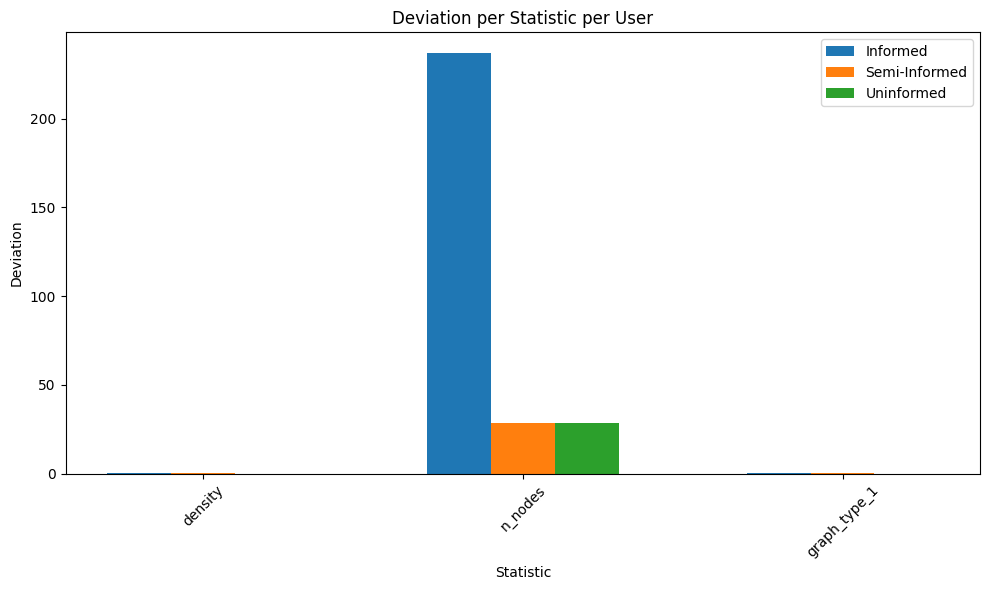

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict

results = [evaluation_informed, evaluation_semi_informed, evaluation_uninformed]

# Flatten the data for plotting
def extract_deviations(results):
    deviations = defaultdict(lambda: defaultdict(list))
    for user, user_data in enumerate(results):
        for vis_type, vis_data in user_data.items():
            for stat, stat_data in vis_data.items():
                if 'deviation' in stat_data:
                    deviations[stat][vis_type].append(stat_data['deviation'])
    return deviations

deviations = extract_deviations(results)

stat_names = list(deviations.keys())
visualization_types = list(set(v for vis_dict in deviations.values() for v in vis_dict.keys()))  # All unique visualization types

# Use these custom labels instead of "User 1", "User 2", "User 3"
user_labels = ['Informed', 'Semi-Informed', 'Uninformed']

bar_width = 0.2
index = np.arange(len(stat_names))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each "user" (informed, semi-informed, uninformed)
for i, user in enumerate(user_labels):
    deviation_values = []
    for stat in stat_names:
        user_devs = []
        for vis_type in visualization_types:
            if len(deviations[stat][vis_type]) > i:
                user_devs.append(deviations[stat][vis_type][i])
            else:
                user_devs.append(0)  # Fill with 0 if the user does not have this visualization type
        deviation_values.append(np.mean(user_devs))  # Average deviation for each statistic

    ax.bar(index + i * bar_width, deviation_values, bar_width, label=user)

# Labeling the axes and the chart
ax.set_xlabel('Statistic')
ax.set_ylabel('Deviation')
ax.set_title('Deviation per Statistic per User')
ax.set_xticks(index + bar_width * (len(user_labels) - 1) / 2)
ax.set_xticklabels(stat_names, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()